red neuronal con variables transformadas y usando solo meses, después intento con quincenas

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import accuracy_score, recall_score

In [2]:
#Cargar base de datos
filepath = "../data/data_globant_cnn_3.csv"

#Lectura
dataset = pd.read_csv(filepath)

In [3]:
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%d%b%y')

In [4]:
dataset.head()

,Date,Position,Seniority,Location,Studio,Client Tag,Project Tag,Team Name,Email Leader,Month,Day,EmployeeID,Engagement_D
0,2023-01-02,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,laura.leon@tec.globant.com,1,2,66,Medio
1,2023-01-03,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,laura.leon@tec.globant.com,1,3,66,Medio
2,2023-01-04,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,laura.leon@tec.globant.com,1,4,66,Medio
3,2023-01-05,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,laura.leon@tec.globant.com,1,5,66,Bajo
4,2023-01-06,Software Developer,0,CO/ANT/MED,Engineering,GWI001,ATLINT,Breaking Badger,laura.leon@tec.globant.com,1,6,66,Medio


In [5]:
#Distribuciones de la discretización

print(dataset["Engagement_D"].value_counts()["Alto"])
print(dataset["Engagement_D"].value_counts()["Medio"])
print(dataset["Engagement_D"].value_counts()["Bajo"])


2807
3691
4357


In [6]:
#Bloques de tiempo más pequeños
def assign_15day_blocks(group):
    group = group.sort_values("Date").reset_index(drop=True)
    
    #Crear el número de bloque: cada 15 filas cambia el valor
    group["15_dias"] = (group.index // 15) + 1
    
    return group

#Aplicar por persona
dataset = dataset.groupby("EmployeeID").apply(assign_15day_blocks).reset_index(drop=True)

C:\Users\romi\AppData\Local\Temp\ipykernel_26752\662383257.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.groupby("EmployeeID").apply(assign_15day_blocks).reset_index(drop=True)


In [7]:
dataset=dataset.drop(columns=["Date", "Email Leader"])

In [8]:
dataset.head()

,Position,Seniority,Location,Studio,Client Tag,Project Tag,Team Name,Month,Day,EmployeeID,Engagement_D,15_dias
0,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,2,0,Medio,1
1,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,3,0,Alto,1
2,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,4,0,Alto,1
3,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,5,0,Alto,1
4,Data Analyst,1,AR/CABA/BA,Data,EDUSYS,CATPRO,Star Wars: The Furry Awakens,1,6,0,Alto,1


In [9]:
#Discretización

categorical_cols = [
    "Position",
    "Location",
    "Studio",
    "Client Tag",
    "Project Tag",
    "Team Name" ]
dataset = pd.get_dummies(dataset, columns=categorical_cols, drop_first=False)

print("Columnas después del OneHot:", len(dataset.columns))

dataset.head()

Columnas después del OneHot: 57


,Seniority,Month,Day,EmployeeID,Engagement_D,15_dias,Position_Business Analyst,Position_Business Intelligence,Position_Cybersecurity Specialist,Position_Data Analyst,...,Team Name_Breaking Badger,Team Name_Fight Club Penguin,Team Name_Finding Nemo's Friends,Team Name_Game of Tones,Team Name_Jurassic Bark,Team Name_Paws and Recreation,Team Name_Star Wars: The Furry Awakens,Team Name_The Great Catsby,Team Name_The Lion Kingpin,Team Name_The Matrix Mice
0,1,1,2,0,Medio,1,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
1,1,1,3,0,Alto,1,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
2,1,1,4,0,Alto,1,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
3,1,1,5,0,Alto,1,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
4,1,1,6,0,Alto,1,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False


In [10]:
#Revolver dataset i.i.d.
from sklearn.utils import shuffle

seed = 1234 

np.random.seed(seed)

dataset = shuffle(dataset)

In [11]:
#Discretización

mapping = {
    "Bajo": 0,
    "Medio": 1,
    "Alto": 2
}

dataset["Engagement_D_num"] = dataset["Engagement_D"].map(mapping)

In [12]:
features = dataset.drop(['Engagement_D', 'Engagement_D_num'], axis=1)

labels = dataset['Engagement_D_num']

In [13]:
features.shape

(10855, 56)

In [14]:
features = features.values.astype(float)

In [15]:
labels_int = labels.values

In [16]:
labels = tf.keras.utils.to_categorical(labels_int, num_classes=3)


In [17]:
#Split train y test.

from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            test_size = 0.30, random_state = 1234)

In [18]:
# Normalización
from sklearn import preprocessing

normalizer = preprocessing.MinMaxScaler().fit(train_features)

train_normalized = normalizer.transform(train_features)

test_normalized = normalizer.transform(test_features)

In [19]:
print(train_normalized.shape)


(7598, 56)


In [20]:
#Red neuronal y optimizador

import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(56,)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(3, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    train_normalized,
    train_labels,
    epochs=300,
    validation_split=0.2,
    batch_size=8,
    verbose=1
)


Epoch 1/300


c:\Users\romi\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5048 - loss: 0.9817 - val_accuracy: 0.5895 - val_loss: 0.8954
Epoch 2/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5701 - loss: 0.8943 - val_accuracy: 0.5908 - val_loss: 0.8462
Epoch 3/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5829 - loss: 0.8598 - val_accuracy: 0.5987 - val_loss: 0.8195
Epoch 4/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6004 - loss: 0.8375 - val_accuracy: 0.6105 - val_loss: 0.8011
Epoch 5/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6066 - loss: 0.8223 - val_accuracy: 0.6309 - val_loss: 0.7901
Epoch 6/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6130 - loss: 0.7997 - val_accuracy: 0.6375 - val_loss: 0.7783
Epoch 7/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6188 - loss: 0.7911 - val_accuracy: 0.6520 - val_loss: 0.7548
Epoch 8/300
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6357 - loss: 0.7735 - val_accuracy: 0.6533

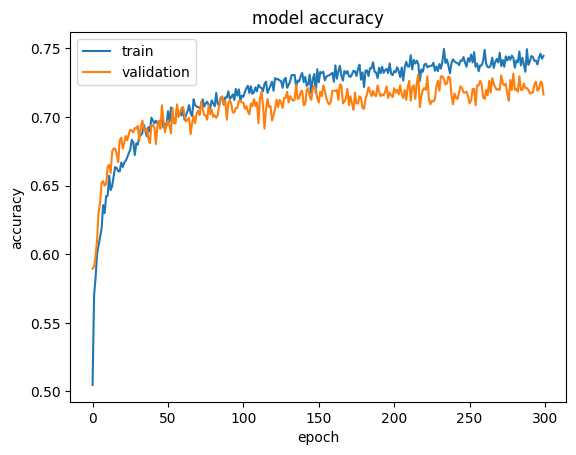

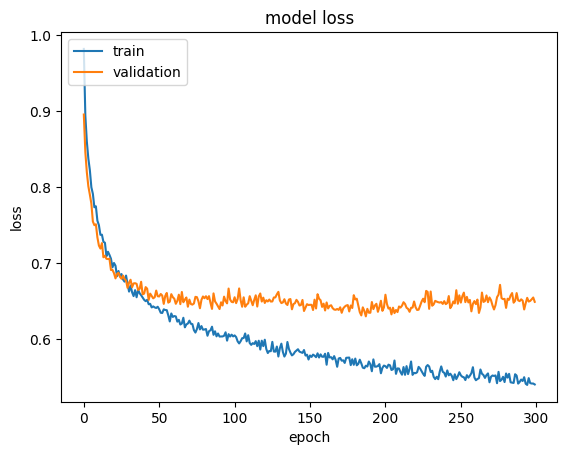

In [21]:
#Accuracy y loss del modelo en training y validation sets

import matplotlib.pyplot as plt
%matplotlib inline
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
#Modelo evaludado en el test set
model.evaluate(test_normalized, test_labels) # [loss, accuracy]

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7209 - loss: 0.6313


[0.6313114762306213, 0.7209088206291199]

In [23]:
#Predicciones
predictions = model.predict(test_normalized)

predictions_int = np.argmax(predictions, axis=1)
true_values_int = np.argmax(test_labels, axis=1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [28]:
true_values_str = ['Bajo' if val==0 else 'Medio' if val==1 else 'Alto' for val in true_values_int]
predictions_str = ['Bajo' if val==0 else 'Medio' if val==1 else 'Alto' for val in predictions_int]

In [30]:
#Matriz de confusión
pd.crosstab(true_values_str, predictions_str, rownames=['True labels'], colnames=['Predicted labels'], labels=['Bajo', 'Medio', 'Alto'])

TypeError: crosstab() got an unexpected keyword argument 'labels'

In [25]:
accuracy_score(true_values_int, predictions_int)

0.7209088117899908

In [32]:
recall_score(true_values_str, predictions_str, average=None, labels=['Bajo', 'Medio', 'Alto'])

array([0.71450266, 0.73982301, 0.70493827])